In [1]:
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, \
                        PegasusTokenizer, BigBirdPegasusForConditionalGeneration
import pandas as pd
test_df = pd.read_csv("dataset/test_processed.csv")

In [2]:
tokenizer_t5 = T5Tokenizer.from_pretrained("google-t5/t5-large")
tokenizer_bigpegasus = PegasusTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")

device = torch.device("cuda") # GPU usage

tokenizer_t5.model_max_length, tokenizer_bigpegasus.model_max_length

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


(1000000000000000019884624838656, 4096)

In [3]:
tokenizer_t5.model_max_length = 4096 
tokenizer_bigpegasus.model_max_length = 4096

In [4]:
def GoBackReadingWindow(model, tokenizer, text, expected_dim):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        if tokenizer.name_or_path == "google-t5/t5-large":
            text = "summarize: " + text
            
        inputs = tokenizer(text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    OVERLAP = int(tokenizer.model_max_length * 0.2)
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = min(start + tokenizer.model_max_length, len(words))
        chunks.append(' '.join(words[start:end]))
        start += tokenizer.model_max_length - OVERLAP

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        if tokenizer.name_or_path == "google-t5/t5-large":
            chunk = "summarize: " + chunk
            
        inputs = tokenizer(chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=300, num_beams=2)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > expected_dim or len(summarized_text.split()) > tokenizer.model_max_length:
        return GoBackReadingWindow(model, tokenizer, summarized_text, expected_dim)
    else:
        if tokenizer.name_or_path == "google-t5/t5-large":
            summarized_text = "summarize: " + summarized_text
        
        inputs = tokenizer(summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [5]:
def ReadingAfterwardsWindow(model, tokenizer, text, expected_dim):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        if tokenizer.name_or_path == "google-t5/t5-large":
            text = "summarize: " + text
        
        inputs = tokenizer(text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    OVERLAP = int(tokenizer.model_max_length * 0.2)
    words = text.split()
    chunks = []
    start = 0

    isfirts = True
    while start < len(words):
        end = min(start + tokenizer.model_max_length, len(words))
        if isfirts:
            chunks.append(' '.join(words[start:end]))
            isfirts = False
        else:
            chunks.append(' '.join(words[start + OVERLAP:end]) + " " + ' '.join(words[start:start + OVERLAP]))
        start += tokenizer.model_max_length - OVERLAP

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        if tokenizer.name_or_path == "google-t5/t5-large":
            chunk = "summarize: " + chunk
        
        inputs = tokenizer(chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=300, num_beams=2)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > expected_dim or len(summarized_text.split()) > tokenizer.model_max_length:
        return ReadingAfterwardsWindow(model, tokenizer, summarized_text, expected_dim)
    else:
        if tokenizer.name_or_path == "google-t5/t5-large":
            summarized_text = "summarize: " + summarized_text
        
        inputs = tokenizer(summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [6]:
def ReadingWithJumpingWindow(model, tokenizer, text, expected_dim):
    torch.cuda.empty_cache()
    if len(text.split()) < tokenizer.model_max_length:
        if tokenizer.name_or_path == "google-t5/t5-large":
            text = "summarize: " + text
        
        inputs = tokenizer(text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    JUMP = 50
    words = text.split()
    chunks = []
    start = 0

    while start < len(words):
        end = min(int(start + tokenizer.model_max_length + JUMP), len(words))
        chunks.append(' '.join(words[int(start):int(start + tokenizer.model_max_length/2)]) \
                        + " " + ' '.join(words[int(start + tokenizer.model_max_length/2) + JUMP:end]))
        start += tokenizer.model_max_length/2

    print(len(chunks))
    
    summarized_chunks = []
    for chunk in chunks:
        if tokenizer.name_or_path == "google-t5/t5-large":
            chunk = "summarize: " + chunk
        
        inputs = tokenizer(chunk,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=300, num_beams=2)
        summarized_chunks.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        torch.cuda.empty_cache()
    
    summarized_text = ' '.join(summarized_chunks)
    
    if len(summarized_text.split()) > expected_dim or len(summarized_text.split()) > tokenizer.model_max_length:
        return ReadingWithJumpingWindow(model, tokenizer, summarized_text, expected_dim)
    else:
        if tokenizer.name_or_path == "google-t5/t5-large":
            summarized_text = "summarize: " + summarized_text
        
        inputs = tokenizer(summarized_text,\
                           return_tensors="pt",\
                           max_length=tokenizer.model_max_length,\
                           truncation=True).to(device)
        outputs = model.generate(**inputs, min_length=15, max_new_tokens=500, num_beams=4, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

All the tests were performed by using just 20 texts for the following reasons:
- Using all the dataset would take days to elaborate (20 texts for the three procedures took 20 hours to complete)
- The statistical method adopted (kruskal) have as an assumption to have at least 5 observations (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

In [7]:
from bert_score import score

F1_t51 = []
F1_bigpegasus1 = []

for index, row in test_df[:20].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    summary_tokens = row["summary_tokens"]
    print(row["reference_tokens"])

    model_bigpegasus = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")
    model_bigpegasus.to(device)
    result_summary = GoBackReadingWindow(model_bigpegasus, tokenizer_bigpegasus, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"BigBird BertScore F1: {F1.item():.2f}")
    F1_bigpegasus1.append(F1.item())
    del model_bigpegasus
    torch.cuda.empty_cache()

    model_t5 = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large")
    model_t5.to(device)
    result_summary = GoBackReadingWindow(model_t5, tokenizer_t5, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t51.append(F1.item())
    del model_t5
    torch.cuda.empty_cache()

sum1 = 0
for _ in F1_t51:
    sum1 += _
print(sum1 / len(F1_t51))

sum1 = 0
for _ in F1_bigpegasus1:
    sum1 += _
print(sum1 / len(F1_bigpegasus1))

4996
2


Input ids are automatically padded from 2084 to 2112 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 519 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article establishes a uniform requirement on the registration of a manager of a qualifying venture capital fund, a euveca manager or a ucits management company and on the cross -border marketing of a qualifying venture capital fund.<n> it also provides for the establishment of a central database on the cross -border marketing of a qualifying venture capital fund.<n> the regulation applies to all : ( 1 ) registered entities in the united states, ( 2 ) registered institutions in the european parliament and of the council, ( 3 ) a credit institution, ( 4 ) a ucits management company, ( 5 ) an alternative investment fund manager in accordance with directive 2011/61/eu, ( 6 ) an investment firm in accordance with directive 2013/36/eu, ( 7 ) a credit institution, a ucits management company, ( 8 ) an alternative investment fund manager in accordance with directive 2014/65/eu, ( 9 ) a manager of a qualifying social entrepreneurship fund, ( 10 ) a manager of a qualifying social entrepreneu

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
2
esma shall establish a central database on cross-border marketing of aifs and ucits. aifms and ucits shall ensure that all marketing communication addressed to investor are identifiable and describe the risk and reward of purchasing unit or share of an aif.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
14373
5


Input ids are automatically padded from 1471 to 1472 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 994 to 1024 to be a multiple of `config.block_size`: 64


this regulation establishes a framework for cooperation with economic operator and for control on product entering the union market.<n> it applies to products made available online or offline by a public body, any non - union public body and any other public body, the protection of the environment and public security and any other public interest protected by that legislation.<n> it applies to every economic operator that makes available to the public a product made available online or offline by a non - union public body, the protection of the environment and public security and any other public interest protected by that legislation.<n> it applies to every authorized representative of the union market and the national market surveillance authority.<n> it applies to every authorized representative of the union market and the national market surveillance authority.<n> it applies to every member state authorized to act as market surveillance authority.<n> it applies to every member stat

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
5
each member state shall designate one or more market surveillance authority in its territory. market surveillance authority shall follow a risk-based approach. they shall take into account possible hazard and non-compliance. product presenting a serious risk shall be withdrawn or recalled.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
2073


Input ids are automatically padded from 2328 to 2368 to be a multiple of `config.block_size`: 64


this directive establishes a framework for the ancillary online service which is ancillary to the broadcast of television and radio programme, and for the retransmission of television and radio programme through the process of direct injection.<n> it applies to television and radio programmes carried by a single broadcasting organisation, or by a combination of television and radio programmes carried by a single broadcasting organisation and the public, and to ancillary online service which are ancillary to the broadcast of those television and radio programmes.<n> it applies to the broadcasting organisation, or by a combination of television and radio programme carried by it and the public, and to the retransmission of those television and radio programme.<n> it is defined in a managed environment, where the retransmission is carried by an operator of broadcasting organisation.<n> it is defined in point ( 1 ) of the second paragraph of regulation ( eu ) 2015/2120, and in point ( 2 ) o

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
directive aims to enhance cross-border access to a greater number of television and radio programme. lay down rule for the transmission of television and radio programme through the process of direct injection. rightholders may exercise their right to grant or refuse the authorisation for a retransmission only through a collective management organisation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
5690
2


Input ids are automatically padded from 2691 to 2752 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 507 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article provides a procedure for an assessment of the effectiveness of an administrative decision made by a member state of the european union in connection with an economic operator s request for an assessment.<n> the procedure requires the competent authority of the member state to provide, within 45 working day of receipt of the request referred to in paragraph 1 of this article, a copy of the administrative decision, the document and information necessary to assist in solving the case, and to provide to the economic operator within 15 working day a report on the status of the investigation and the determination of the concern.<n> the procedure is independent of the scientific or technical justifications provided for the assessment.<n> the procedure is independent of the time limit for providing the additional information necessary to assist in solving the case.<n> the procedure is independent of the time limit for providing the additional information necessary to assist in sol

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
2
eu regulations aim to strengthen the functioning of the internal market by improving the application of the principle of mutual recognition. they apply to good that are subject to article 34 tfeu and which are lawfully marketed in another member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3990
this paper describes the implementation of the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name in the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> the.eu tld.<n> the.<n> the.eu.<n> the.e

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
.eu country code top-level domain ( cctld ) aims to support the digital single market, to build an online union identity and to encourage cross-border online activity. it also lay down the legal and general policy framework within which the designated registry is to function. a registered domain name shall be unavailable for further registration until the registration ha expired without renewal.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
11101
4


Input ids are automatically padded from 1441 to 1472 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 727 to 768 to be a multiple of `config.block_size`: 64


this article describes the monitoring and evaluation procedure for the implementation of the eurocentrum for energy storage ( cef ), and establishes a monitoring and evaluation framework for the selection of cross - border projects in the field of renewable energy. <n> this article describes the monitoring and evaluation procedure for the implementation of the eurocentrum for energy storage ( cef ), and establishes a monitoring and evaluation framework for the selection of cross - border projects in the field of renewable energy. <n> this article describes the monitoring and evaluation procedure for the implementation of the eurocentrum for energy storage ( cef ), and establishes a monitoring and evaluation framework for the selection of cross - border projects in the field of renewable energy. <n> [ multiblock footnote omitted ] [ multiblock footnote omitted ] [ multiblock footnote omitted ]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
4
cross-border project in the field of renewable energy shall contribute to decarbonisation, to completing the internal energy market and to enhancing the security of supply. eligible action include study, work and other accompanying measure necessary for the management and implementation of the cef.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
7399
3


Input ids are automatically padded from 910 to 960 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 849 to 896 to be a multiple of `config.block_size`: 64


this paper transposes the definitions of terrorist content and of dissemination of terrorist content on the internet into a new regulation that applies to the dissemination of terrorist content on the internet.<n> it applies to all service provided by a member state of the european union, irrespective of its place of main establishment, and to any hosting service provider offering service in the union.<n> it applies to the member state where the hosting service provider resides or where it legal representative resides or is established, and to it legal representative and its representatives, irrespective of their place of main establishment.<n> it applies to the fundamental right of expression and information, in particular the freedom of expression and information in an open and democratic society.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
3
hosting service provider shall take specific measure to address dissemination to the public of terrorist content online. terrorist content and related data shall be preserved for six month. the delegation of power referred to in article 19 may be revoked at any time by the european parliament or by the council.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
21083
7


Input ids are automatically padded from 1582 to 1600 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1836 to 1856 to be a multiple of `config.block_size`: 64


this paper describes the implementation of the interaction between the eu and the non - nuclear sectors, in particular, the interaction through the so - called eit, under the framework of the2021-2027, and its impact on the scientific and societal development of the european union.<n> the interaction between the eu and the non - nuclear sectors was introduced in the framework of the2021/2094 interaction between the eu and the non - nuclear sectors, in particular, under the framework of the so - called eit, for the period 2021 to 2027.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
7
pillar i 'excellent science' shall be the focus of the programme. pillar ii 'innovative europe' shall be the focus of the eit. erdf, esf+, emfaf and eit may co-fund actions under programme.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
31669
10


Input ids are automatically padded from 2501 to 2560 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2612 to 2624 to be a multiple of `config.block_size`: 64


this article transposes and harmonises the galileo and eea union programme.<n> it provides a framework for the efficient and transparent implementation of the eea union programme in the framework of non - local, local and semi - local partnership approach.<n> it guarantees the fair and transparent management of the eea union programme, the preservation of the member state s interests and the financial interest of the union, and it provides a framework for the efficient implementation of the eea union programme in the framework of non - local, local and semi - local partnership approach.<n> it applies to the satellite constellations of the european space agency ( esa ), the european satellite network ( ensn ), the european space agency ( esa ) core user, and to the third country and international organisation ( icao ).<n> it applies to the satellite constellations of the european union ( eu ), the european satellite network ( ensn ), the european space agency ( esa ) core user, and to t

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.77
10
eu space programme aims to provide high-quality and up-to-date space-related data, information and service. it shall foster an innovative and competitive european space sector, upstream and downstream. access to govsatcom service shall be subject to a request from the potential user.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8289
3


Input ids are automatically padded from 1935 to 1984 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 644 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this paper describes the procedures followed in the implementation of the stichtingzentrum fr strahlenforschung, the union programme for the promotion of digital technologies in the framework of the bloc.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
3
programme aims to support and accelerate the digital transformation of the european economy, industry and society. only action contributing to the achievement of the objective laid down in article 3 to 8 shall be eligible for funding.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
9686
3


Input ids are automatically padded from 3563 to 3584 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 875 to 896 to be a multiple of `config.block_size`: 64


this article describes the scope and the strategy of the business support programme for small and medium sized enterprises ( smes ) in the framework of the union programme.<n> it describes the procedure followed in the implementation of the eu6 project, in the framework of the bloch2021 programme.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
3
eu single market programme aims to improve the functioning of the internal market, the competitiveness and sustainability of enterprise. programme may finance up to 100 % of eligible cost for financial support to third party and up to 90 % of eligible cost for other cost category.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
7910
3


Input ids are automatically padded from 1493 to 1536 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 767 to 768 to be a multiple of `config.block_size`: 64


this article transposes the directive of 13 april 2016 on the accession of a non - european member state to the union of the netherlands.<n> it provides for the exchange of information between the member state and the commission concerning the grant of an authorisation for the acquisition and possession of firearm and the refusal to grant such an authorisation.<n> it provides for the verification of the security of those components and the transfer of those components to the member state.<n> it provides for the authentication of the security of those components and the transfer of those components to the member state.<n> it provides for the verification of the security of those components and the transfer of those components to the member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
3
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. firearms classified in category a, b or c may not be transferred to another member state. firearms deactivated prior to 8 april 2016 must be transferred to another member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
5847
2


Input ids are automatically padded from 2884 to 2944 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 445 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article establishes the framework for the technologically neutral and interoperable maritime single window environment ( emswe ), which consists of a network of national single window with a well defined reporting interface and includes data exchange via a well defined common service for user registry and access management, and other relevant system, which includes a graphical user interface for communication with declarants.<n> it also provides a definition of the data element of the emswe data set, which includes all relevant data, such as the data element of the emswe data set, the ship, the member state and the declarants.<n> it enables, where applicable, the connection with other reporting obligation, which could, where applicable, allow, where applicable, the extraction of data from the relevant national single window.<n> it also provides a means for the interoperability of the data between the member state and the emswe, which could, where applicable, allow, where applicabl

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
2
emswe is a system for storing and exchanging ship-related data. it is intended to facilitate the reporting of dangerous and polluting goods. by 15 august 2027, the commission shall establish a common hazmat database. it shall be linked to the relevant entry in the mar-cis database.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
10969
4


Input ids are automatically padded from 1285 to 1344 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 899 to 960 to be a multiple of `config.block_size`: 64


this paper describes the procedure adopted by the european commission to ensure the interoperability of electronic road toll systems ( eets ) on the territory of a member state, and the measures taken by the member state to ensure the interoperability of eets on the territory of a non - member state.<n> it also describes the procedure adopted by the member state to take the measure necessary to ensure that an operational road toll system on the territory of a non - member state is not invalidated, and the measures taken by the member state to ensure that an operational road toll system on the territory of a non - member state is not activated by an eets user.<n> the procedure adopted by the european commission to ensure the interoperability of electronic road toll systems ( edts ) on the territory of a member state provides a framework for the assessment of the suitability of edts constituent, including the content and format of the ec declaration, and a mechanism for the commission an

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
4
eets provider shall make available to eets user a customised obe. each member state shall designate a single contact office for eets provider. each member state shall keep a national electronic register of the eets domain.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3579


Input ids are automatically padded from 4038 to 4096 to be a multiple of `config.block_size`: 64


this regulation establishes the framework for the creation of a european network of immigration liaison officer deployed to a third country by a member state, the commission and the union agency, through the creation of a european network of immigration liaison officer.<n> it shall be defined within the framework of their responsibility determined by the deploying authority and in accordance with the provision, including those on the protection of personal data, laid down in union and national law and in any arrangement concluded with third country or international organisation.<n> it shall cover the following issue in particular : ( a ) european integrated border management at the external border, with a view to managing migration effectively ; ( b ) migratory flow originating from or transiting through the third country ; ( c ) route used by immigrant in the country of origin, including when appropriate, with local authority, international organisation and relevant union agency ; ( d

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
a steering board for a european network of immigration liaison officer is established. the steering board shall be composed of one representative of each member state, two representative of the commission, one representative of europol and one representative of easo. the information to be exchanged via the secure web-based information exchange platform shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3503


Input ids are automatically padded from 3978 to 4032 to be a multiple of `config.block_size`: 64


the aim of this regulation is to strengthen the security standard applicable to the identity card issued by a member state to its national and residence document issued by member state to union citizen and their family member when exercising their right to free movement.<n> it establishes a security standard for the processing of biometric data of the holder of the identity card.<n> it ensures the security of the card, the validity of the card and the inclusion of the biometric identifier on the front side of the card.<n> it also ensures that the member state comply with the security standard and the efficiency of the minimum security standard set out in directive 2004/38 of the european union.<n> the security standard also ensures the security of the registration certificate and the document certifying permanent residence of the holder of the identity card.<n> it ensures the security of the card and the efficiency of the minimum security standard set out in directive 2004/38 of the eu

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
identity card issued by member state to their own national and residence document issued by member state to union citizen and their family member. card shall have a minimum period of validity of five year and a maximum period of validity of ten year. person in respect of whom fingerprinting is physically impossible shall be exempt from the requirement to give fingerprint.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11563
4


Input ids are automatically padded from 2197 to 2240 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1129 to 1152 to be a multiple of `config.block_size`: 64


this paper describes the implementation of the fundamental right of access, rectification and erasure of data relating to a person in the framework of the ecris-tcn, the european criminal record database.<n> ecris-tcn is the database to which the member states of the international centre for nuclear research ( icn ) and of the european centre for nuclear research ( eppo ) have access.<n> it is the central database for nuclear research related to the identification of nuclear targets and nuclear energy sources. <n> this paper describes the implementation of the fundamental right of access, rectification and erasure of data relating to a person in the framework of the ecris-tcn, the european criminal record database.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
4
ecris-tcn is a system to identify member states holding criminal record information. member states shall ensure their national ecris implementation software allows them to query ecris-tcn. ecris-tcn was created in response to the european commission's ecrs.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31622
10


Input ids are automatically padded from 2372 to 2432 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2361 to 2368 to be a multiple of `config.block_size`: 64


this regulation establishes a framework to ensure interoperability between the entry/exit system ( ee ), the visa information system ( vi ), the european travel information system ( etias ), eurodac, the schengen information system ( si ) and the european criminal record information system ( ecris-tcn ).<n> it also lays down provision on data quality requirement, on a universal message format ( umf ), on a central repository for reporting and statistic ( crrs ) and on the responsibility of the member state and of the european agency for the operational management of large - scale it system in the area of freedom, security and justice ( eu lisa ), with respect to the design, development and operation of the interoperability component.<n> the framework is based on the principles of data portability, privacy and security.<n> it provides the framework for the processing and use of personal data in the ee, vi, etias, eurodac and ecris-tcn.<n> the data are stored in the common identity repos

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
10
the esp shall query the ee, etias, vi, si, eurodac, ecris-tcn, the cir, the mid, europol data and the interpol database. it shall provide no information regarding data in eu information system. eu-lisa shall ensure that each authority entitled to access the interoperability component takes the necessary measure to ensure compliance with this regulation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
27198
9


Input ids are automatically padded from 1126 to 1152 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 2198 to 2240 to be a multiple of `config.block_size`: 64


this article provides a common framework for all member states to determine the amount of financial support for the generation of electricity from renewable sources.<n> this includes setting up of a universal support scheme for the generation of electricity from renewable sources, which includes the price of support.<n> this includes ensuring that support is granted in an open, transparent and competitive manner.<n> in addition, member states may exempt small - scale installation and demonstration project from the procedure and may assist them throughout the negotiation process, including quantitative and qualitative data on the direct and indirect cost and benefit of cooperation, a well a with guidance and technical expertise.<n> the framework includes a customer - oriented and dynamic framework for the development and deployment of renewable energy and energy storage in the market.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.82
9
directive establishes a common framework for the promotion of energy from renewable source. it also lay down rule on financial support for electricity from renewable source. member state shall ensure that the share of energy from renewable source in the union's gross final consumption of energy in 2030 is at least 32 %.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
51813
16


Input ids are automatically padded from 2991 to 3008 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3948 to 3968 to be a multiple of `config.block_size`: 64


this article transposes thecherry - zeilinger s directive on electronic communication services into the internal market.<n> it provides for an unambiguous definition of a market which is different from those defined in the directive, and a measure which would affect trade between member state and the commission in the promotion of this policy, inter alia, in the economic, social, public interest, freedom of expression, cultural and, in particular, in the establishment and functioning of the internal market in electronic communication.<n> it specifies the general authorisation for the regulation of electronic communication services in a transparent manner, in accordance with consumer and national regulatory laws.<n> it provides conditions for the member state to provide such network or service and for the member state to impose an administrative charge for the provision of such network or service.<n> it also provides conditions for the member state to ensure the effective and efficient 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
16
eu directive establishes a harmonised framework for the regulation of electronic communication network, electronic communication service, associated facility and associated service. national regulatory authority shall ensure that they act impartially, transparently and in a timely manner. member state may restrict or withdraw right to use radio spectrum or numbering resource before expiry of the period for which they were granted.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
0.8108541995286942
0.7966991335153579


In [8]:
F1_t52 = []
F1_bigpegasus2 = []

for index, row in test_df[:20].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    summary_tokens = row["summary_tokens"]
    print(row["reference_tokens"])

    model_bigpegasus = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")
    model_bigpegasus.to(device)
    result_summary = ReadingAfterwardsWindow(model_bigpegasus, tokenizer_bigpegasus, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"BigBird BertScore F1: {F1.item():.2f}")
    F1_bigpegasus2.append(F1.item())
    del model_bigpegasus
    torch.cuda.empty_cache()

    model_t5 = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large")
    model_t5.to(device)
    result_summary = ReadingAfterwardsWindow(model_t5, tokenizer_t5, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t52.append(F1.item())
    del model_t5
    torch.cuda.empty_cache()

sum2 = 0
for _ in F1_t52:
    sum2 += _
print(sum2 / len(F1_t52))

sum2 = 0
for _ in F1_bigpegasus2:
    sum2 += _
print(sum2 / len(F1_bigpegasus2))

4996
2


Attention type 'block_sparse' is not possible if sequence_length: 408 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article establishes a uniform requirement on the registration of a manager of a qualifying venture capital fund, a euveca manager or a ucits management company and on the cross -border marketing of a qualifying venture capital fund.<n> it also provides for the establishment of a central database on the cross -border marketing of a qualifying venture capital fund.<n> it applies to : alternative investment fund manager ; ucits management company, including any ucits which ha not designated a ucits management company ; euveca manager and ucits management company.<n> it applies to a third party, a manager of a qualifying social entrepreneurship fund, a ucits management company, an alternative investment fund manager, or act a tied agent.<n> this article establishes a uniform requirement on the registration of a manager of a qualifying social entrepreneurship fund, a euveca manager or a ucits management company and on the cross -border marketing of a qualifying social entrepreneurship 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
2
esma shall establish a central database on cross-border marketing of aifs and ucits. aifms and ucits shall ensure that all marketing communication addressed to investor are identifiable. a third party shall only engage in pre-marketing on behalf of an authorised manager of a qualifying social entrepreneurship fund.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
14373
5


Input ids are automatically padded from 1289 to 1344 to be a multiple of `config.block_size`: 64


this regulation establishes a framework for cooperation with economic operator and for control on product entering the union market.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
5
each member state shall designate one or more market surveillance authorities in its territory. market surveillance authority shall ensure that product presenting a serious risk are withdrawn or recalled. a union product compliance network ( adcos) is established to facilitate the uniform application of union harmonisation legislation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
2073
this directive establishes a framework for the ancillary online service which is ancillary to the broadcast of television and radio programme, and for the retransmission of television and radio programme through the process of direct injection.<n> it applies to television and radio programmes carried by a single broadcasting organisation, or by a combination of television and radio programmes carried by a single broadcasting organisation and the public, and to ancillary online service which are ancillary to the broadcast of those television and radio programmes.<n> it applies to the broadcasting organisation, or by a combination of television and radio programme carried by it and the public, and to the retransmission of those television and radio programme.<n> it is defined in a managed environment, where the retransmission is carried by an operator of broadcasting organisation.<n> it is defined in point ( 1 ) of the second paragraph of regulation ( eu ) 2015

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
directive aims to enhance cross-border access to a greater number of television and radio programme. lay down rule for the transmission of television and radio programme through the process of direct injection. rightholders may exercise their right to grant or refuse the authorisation for a retransmission only through a collective management organisation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
5690
2


Attention type 'block_sparse' is not possible if sequence_length: 571 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article describes the procedure under which an economic operator or a competent authority of another member state may provide to the commission, within 15 working day, additional information relevant for verifying data and document supplied by the economic operator during the assessment referred to in paragraph 2 of this article.<n> it also describes the procedure set out for the commission to obtain the additional information and document provided by the economic operator during the assessment referred to in paragraph 2.<n> the information provided in this article is in accordance with the principle of mutual recognition and the national administrative procedure applicable to specific good or good of a specific type in the territory in which the product contact point is established and information on whether those good or good of that type are subject to prior authorisation under national law.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
2
eu regulations aim to strengthen the functioning of the internal market by improving the application of the principle of mutual recognition. they apply to good that are subject to article 34 tfeu and which are lawfully marketed in another member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3990
this paper describes the implementation of the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name in the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> the.eu tld.<n> the.<n> the.eu.<n> the.e

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
.eu country code top-level domain ( cctld ) aims to support the digital single market, to build an online union identity and to encourage cross-border online activity. it also lay down the legal and general policy framework within which the designated registry is to function. a registered domain name shall be unavailable for further registration until the registration ha expired without renewal.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
11101
4


Input ids are automatically padded from 892 to 896 to be a multiple of `config.block_size`: 64


this paper describes the framework adopted in the framework of the eu fp6 pilot project.<n> the main objectives of the pilot project are the development of digital infrastructure in the outermost part of the union and the construction of a submarine cable connecting the outermost part of the union with the port of slovakia.<n> the pilot project involves the construction of an optical fibre network connecting the outermost part of the union with the port of slovakia, of a submarine cable connecting the outermost part of the union with the port of slovakia, and of a fibre network connecting the outermost part of the union with the port of slovakia.<n> the eu grant this paper describes the criteria adopted for the decision to choose the eu cohesion project for a specific objective, the co- financing rate, the total eligible cost, and the impact assessment.<n> the purpose of this regulation is to provide a monitoring and evaluation framework for the implementation of the eu cohesion projec

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
4
up to 1 % of the amount referred to in paragraph 1 may be used to finance technical and administrative assistance for the implementation of the cef. the amount transferred from the cohesion fund shall be made available immediately on a competitive basis to all member state eligible for funding.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
7399
3


Input ids are automatically padded from 850 to 896 to be a multiple of `config.block_size`: 64


this paper introduces and harmonises the so - called solidarity of the internet infrastructure with terrorism ( sii ) which was adopted by the european commission and by the european parliament and by the council on 13 april 2016 in the framework of the so - called solidarity of the internet infrastructure with terrorism ( sii ). <n> # 1 # 1 # 1 # 1 # 1 # 1 # 1 # 1 # 1 @xmath0 # 1 # 1 @xmath1 # 1 # 1 @xmath2 # 1 # 1 # 1 @xmath3 # 1 # 1 # 1 @xmath4 # 1 # 1 # 1 @xmath5 # 1 # 1 # 1 @xmath6 # 1 # 1 # 1 @xmath7 # 1 # 1 # 1 # 1 @xmath8 # 1 # 1 # 1 # 1 @xmath9 # 1 # 1 # 1 # 1 @xmath10 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#10 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#10 # 1#2#3#4#5#6#7#8#9 # 1#2#3#4#5#6#7#8#9 # 1#2#3#8#9 # 1 _ # 1 _ # 2 _ # 1 _ # 2 _ # 1 _ # 2 _ # 1 _ # 2 _ # 1 _ # 1 _ # 2 _ # 1 _ # 1 _ # 2 _ # 1 _ # 1 _ # 2 _ # 1 _ # 1 _ # 1 _ # 1 _ # 2 _ # 1

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.71
3
a hosting service provider shall take specific measure to address the dissemination to the public of terrorist content online. the commission shall adopt delegated act in accordance with article 20. it shall amend the annex to the regulation to address a possible need for improvement.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
21083
7


Input ids are automatically padded from 1733 to 1792 to be a multiple of `config.block_size`: 64


this paper describes the set up of a union funded co - fund for scientific and technological programme.<n> it provides for the coverage of the risk associated with the non - recovery of sum due by the union body, the mutual insurance mechanism for the commission and the relevant funding body, the monitoring and control of the programme, the management of the result, open access to the data and the security of the result.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
7
pillar i of the programme aims to tackle climate change. pillar ii of the programme aims to promote 'innovative europe' priority shall be given to innovative smes. each beneficiary shall own the result it generates.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
31669
10


Input ids are automatically padded from 2407 to 2432 to be a multiple of `config.block_size`: 64


this article provides the general rules for the implementation of the union programme'of the european union under the framework of the pre - commercial procurement procedure.<n> it provides the general rules for the implementation of the union programme'of the european union under the framework of the pre - commercial procurement procedure.<n> it provides the general rules for the implementation of the union programme'of the european union under the framework of the pre - commercial procurement procedure.<n> it applies to the satellite constellations of the european space agency ( esa ), the european satellite network ( ensn ), the european space agency ( esa ) core user, and to the third country and international organisation ( icao ).<n> this article describes the implementation of the data protection in the framework of the pre - commercial procurement procedure.<n> it applies to the satellite constellations of the european space agency ( esa ), the european satellite network ( ensn

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.76
10
eu space programme aims to provide high-quality and up-to-date space-related data, information and service. it shall foster an innovative and competitive european space sector, upstream and downstream. it shall include measure to foster entrepreneurship and skill, in particular for smes and start-ups.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8289
3


Attention type 'block_sparse' is not possible if sequence_length: 491 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this paper establishes an operational framework for monitoring and evaluation of the performance of the union programme and of its related delegated actions.<n> it also establishes a framework for the assessment of the impact of the delegated actions on the union and on the recipient of the union funding.<n> the framework includes the assessment of the implementation of the programme, the monitoring of the implementation, the assessment of the impact of the programme and the evaluation of the results.<n> it describes the procedure followed by the commission for implementation of the cohesion programme for @xmath0 years for @xmath1 years in the framework of the union approach.<n> the procedure includes the assessment of the implementation of the programme, the monitoring of the implementation, the assessment of the impact of the programme and the evaluation of the results.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
3
programme aims to support and accelerate the digital transformation of the european economy, industry and society. funding for action which do not comply with ethical requirement may be suspended, terminated or reduced at any time.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
9686
3


Input ids are automatically padded from 855 to 896 to be a multiple of `config.block_size`: 64


this article describes the conditions under which a non - profit - making entity may be awarded a grant under the consumer - protection programme in the framework of the european union ( eu ) no 1025/2012.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
3
eu single market programme aims to improve the functioning of the internal market, the competitiveness and sustainability of enterprise. the total cost of administrative and technical support under the programme shall not exceed 5 % of the value of the financial envelope.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
7910
3


Input ids are automatically padded from 779 to 832 to be a multiple of `config.block_size`: 64


this article introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between member states.<n> it introduces a system of checks for the transfer of semi - automatic and telescopic - fire weapons between 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.76
3
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. a 'european firearm pas' shall be issued on request by the competent authority of a member state to a person lawfully entering into possession of and using firearm. member state shall ensure that each firearm and each essential component subject to this directive is recorded.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
5847
2


Attention type 'block_sparse' is not possible if sequence_length: 548 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article establishes the framework for the technologically neutral and interoperable maritime single window environment ( emswe ).<n> it provides a definition of the data element of the emswe data set, which includes all relevant data, such as the data element of the emswe data set, the member state and the declarants.<n> it enables, where applicable, the connection with other reporting obligation, which could, where applicable, allow, where applicable, the extraction of data from the relevant national single window.<n> it also provides a means for the interoperability of the data between the member state and the emswe, which could, where applicable, allow, where applicable, the exchange of data between the member state and the emswe.<n> it also provides a means for the interoperability of the data between the member state and the emswe, which could, where applicable, allow, where applicable, the exchange of data between the member state and the emswe. <n> this paper describes the 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
2
emswe is a harmonised interface for the electronic transmission of information. it is intended to facilitate the electronic transmission of information. member states shall establish and amend emswe data set.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
10969
4


Input ids are automatically padded from 877 to 896 to be a multiple of `config.block_size`: 64


this paper describes the procedures adopted by the european commission in adopting the measures necessary to ensure the interoperability of eets on toll systems and the member state measures necessary to ensure that toll charger cooperates non - independently with eets provider and notified body in order to obtain invalidated obes, and the measures taken by the member state to ensure that the member state is able to take action to ensure the interoperability of eets on toll systems. <n> [ [ keywords ] ] keywords : + + + + + + + + + registration, payment and toll collection.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
4
eets provider shall make available to eets user a customised obe. member state shall take the measure necessary to ensure that eets provider maintain coverage of all eets domain. eets provider shall be entitled to be remunerated by the toll charger.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
3579
this regulation establishes the framework for the creation of a european network of immigration liaison officer deployed to a third country by a member state, the commission and the union agency, through the creation of a european network of immigration liaison officer.<n> it shall be defined within the framework of their responsibility determined by the deploying authority and in accordance with the provision, including those on the protection of personal data, laid down in union and national law and in any arrangement concluded with third country or international organisation.<n> it shall cover the following issue in particular : ( a ) european integrated border management at the external border, with a view to managing migration effectively ; ( b ) migratory flow originating from or transiting through the third country ; ( c ) route used by immigrant in the country of origin, including when appropriate, with local authority, international organisation and 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
a steering board for a european network of immigration liaison officer is established. the steering board shall be composed of one representative of each member state, two representative of the commission, one representative of europol and one representative of easo. the information to be exchanged via the secure web-based information exchange platform shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3503
the aim of this regulation is to strengthen the security standard applicable to the identity card issued by a member state to its national and residence document issued by member state to union citizen and their family member when exercising their right to free movement.<n> it establishes a security standard for the processing of biometric data of the holder of the identity card.<n> it ensures the security of the card, the validity of the card and the inclusion of the biometric identifier on the front side of the card.<n> it also ensures that the member state comply with the security standard and the efficiency of the minimum security standard set out in directive 2004/38 of the european union.<n> the security standard also ensures the security of the registration certificate and the document certifying permanent residence of the holder of the identity card.<n> it ensures the security of the card and the efficiency of the minimum security standard set out in 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
identity card issued by member state to their own national and residence document issued by member state to union citizen and their family member. card shall have a minimum period of validity of five year and a maximum period of validity of ten year. person in respect of whom fingerprinting is physically impossible shall be exempt from the requirement to give fingerprint.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11563
4


Input ids are automatically padded from 974 to 1024 to be a multiple of `config.block_size`: 64


this paper describes the implementation of the monitoring and evaluation of the lawfulness and the lawfulness of the data processing operation of eu-lisa concerning ecris-tcn and of the monitoring and evaluation of the lawfulness and the lawfulness of the ecris-tcn implementation implemented by eu-lisa.<n> it also describes the cooperation among the member states, eu-lisa, the european data protection supervisor and the national supervisory authority in the implementation of the aforementioned monitoring and evaluation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
4
ecris-tcn is a system to identify member states holding criminal record information. member states shall ensure their national ecris implementation software allows them to query ecris-tcn. the power to adopt delegated act is conferred on the commission for an indeterminate period of time from 11 june 2019.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
31622
10


Input ids are automatically padded from 2589 to 2624 to be a multiple of `config.block_size`: 64


this article describes the implementation of the ecris system for the identification of member state holding conviction information on third - country national and stateless person ( ecris-tcn ), supplemented by the european criminal record information system ( eu lisa ), under the framework of the eu - lisa common identity repository ( cir ).<n> it also describes the implementation of the e - alert system ( esp ) under the framework of the eu - lisa common identity repository ( cir ). <n> this article describes the implementation of the ecris system for the identification of member state holding conviction information on third - country national and stateless person ( ecris-tcn ), supplemented by the european criminal record information system ( eu lisa ) under the framework of the eu - lisa common identity repository ( cir ).<n> it also describes the implementation of the e - alert system ( esp ) under the framework of the eu - lisa common identity repository ( cir ).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
10
the esp shall query the ee, etias, vi, si, eurodac, ecris-tcn, the cir, the mid, europol data and the interpol database. data shall be stored in the shared bm only for a long a the corresponding biometric data are stored in the cir. eu-lisa shall ensure the security of the processing of personal data.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
27198
9
this article introduces a novel approach to promote the use of renewable energy in the heating and cooling sector, based on the definition of a share of renewable energy for the heating and cooling sector and on the establishment of an annual increase in that share.<n> the objective is to increase the share of renewable energy produced from waste heat and cold in the heating and cooling sector by at least an indicative 1,3 point per unit of final energy consumption in that sector.<n> this increase shall be limited to an indicative 1,1 point per unit of final energy consumption in that sector, where appropriate, member states may use the best available technology to implement that increase.<n> this article describes the implementation of energy interconnection between a member state and a third country under the framework of the renewable and sustainable energy interconnection ( rsi ).<n> it also describes the general procedure adopted by the commission to 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
9
the directive establishes a common framework for the promotion of energy from renewable source. it also lay down rule on financial support for electricity from renewable source. member state shall ensure that the share of energy from renewable source in the union's gross final consumption of energy in 2030 is at least 32 %.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
51813
16


Input ids are automatically padded from 3927 to 3968 to be a multiple of `config.block_size`: 64


this article transposes the directive on electronic communication network and service ( no 182/2011 ) to the telecommunication sector.<n> it provides a framework for regulation of electronic communication network and service in a transparent manner.<n> it provides a framework for the resolution of cross - border coordination and harmful interference between member state undertakings.<n> it provides a framework for the regulation of the next - generation telecommunication network market, including mobile and fixed voice termination, and establishes a mechanism to ensure fair and non - negative values for end - users.<n> it also provides a framework for the national regulatory authority to take decision in the case of a dispute arising between member state, the member state concerned and the public at large. <n> consumer protection, electronic communication network, regulatory framework, cross - border coordination and harmful interference


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
16
eu directive establishes a harmonised framework for the regulation of electronic communication network, electronic communication service, associated facility and associated service. it lay down task of national regulatory and other competent authority. national regulatory authority shall be entitled to collect necessary data. member state shall ensure that end-users with disability can access service provided under the number ‘ 116000’ to the greatest extent possible.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
0.8104139298200608
0.7914794653654098


In [9]:
F1_t53 = []
F1_bigpegasus3 = []

for index, row in test_df[:20].iterrows():
    reference_text = row["reference"]
    reference_summary = row["summary"]
    summary_tokens = row["summary_tokens"]
    print(row["reference_tokens"])

    model_bigpegasus = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")
    model_bigpegasus.to(device)
    result_summary = ReadingWithJumpingWindow(model_bigpegasus, tokenizer_bigpegasus, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"BigBird BertScore F1: {F1.item():.2f}")
    F1_bigpegasus3.append(F1.item())
    del model_bigpegasus
    torch.cuda.empty_cache()

    model_t5 = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large")
    model_t5.to(device)
    result_summary = ReadingWithJumpingWindow(model_t5, tokenizer_t5, reference_text, summary_tokens)
    print(result_summary)
    P, R, F1 = score([result_summary], [reference_summary], lang='en', verbose=False)
    print(f"T5 BertScore F1: {F1.item():.2f}")
    F1_t53.append(F1.item())
    del model_t5
    torch.cuda.empty_cache()

sum3 = 0
for _ in F1_t53:
    sum3 += _
print(sum3 / len(F1_t53))

sum3 = 0
for _ in F1_bigpegasus3:
    sum3 += _
print(sum3 / len(F1_bigpegasus3))

4996
3


Input ids are automatically padded from 3467 to 3520 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1090 to 1152 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 804 to 832 to be a multiple of `config.block_size`: 64


this paper is concerned with the regulation of cross -border marketing of qualifying social entrepreneurship funds in the framework of the sloan digital sky survey by the european organization for nuclear research ( euveca ), the eu agency for research and nuclear energy ( aor ), the eu agency for research and nuclear energy ( eusef ), the eu agency for research and nuclear energy ( aor ) and the eu agency for research and nuclear energy ( euveca ), respectively.<n> it applies to alternative investment fund manager, ucits management company, euveca manager and eusef manager.<n> it applies to all ucits, euveca manager and eusef manager.<n> it applies to all ucits which ha not designated a ucits management company.<n> it applies to all ucits which ha not designated a ucits management company.<n> it applies to all ucits which ha not designated a ucits management company.<n> it applies to all ucits which ha not designated a ucits management company.<n> it applies to all ucits which ha not 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.77
3
esma shall establish a central database on cross-border marketing of aifs and ucits. the database shall be kept up to date and include information on access to collective redress mechanism in the event of litigation. by 2 february 2022, the database shall be kept up to date.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
14373
8


Input ids are automatically padded from 2381 to 2432 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 42 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article establishes a platform for structured coordination and cooperation between union harmonisation legislation and the commission, to streamline the practice of market surveillance within the union, and to facilitate the cooperation among the network and the commission, and to ensure a consistent enforcement of union law.<n> it provides technical assistance, cooperation with third country and the development of the information and communication system enabling it to receive automatic flow of electronic data from the national custom system.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
8
each member state shall designate one or more market surveillance authorities in its territory. market surveillance authority shall carry out appropriate check on the characteristic of product on an adequate scale. they may also carry out unannounced on-site inspection and physical check of product.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
2073
this directive establishes a framework for the ancillary online service which is ancillary to the broadcast of television and radio programme, and for the retransmission of television and radio programme through the process of direct injection.<n> it applies to television and radio programmes carried by a single broadcasting organisation, or by a combination of television and radio programmes carried by a single broadcasting organisation and the public, and to ancillary online service which are ancillary to the broadcast of those television and radio programmes.<n> it applies to the broadcasting organisation, or by a combination of television and radio programme carried by it and the public, and to the retransmission of those television and radio programme.<n> it is defined in a managed environment, where the retransmission is carried by an operator of broadcasting organisation.<n> it is defined in point ( 1 ) of the second paragraph of regulation ( eu ) 2015

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
directive aims to enhance cross-border access to a greater number of television and radio programme. lay down rule for the transmission of television and radio programme through the process of direct injection. rightholders may exercise their right to grant or refuse the authorisation for a retransmission only through a collective management organisation.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
5690
3


Input ids are automatically padded from 3961 to 3968 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1783 to 1792 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 788 to 832 to be a multiple of `config.block_size`: 64


this article establishes the procedure for the assessment of the principle of mutual recognition between a member state and a member state of destination, and for the provision of that assessment to the competent authority of the member state of destination.<n> it applies to all member states that are marketed in the field of agricultural product, and to all agricultural products that are subject to a national technical rule applicable in the member state.<n> it applies to the agricultural product of a member state and to all agricultural products that are subject to a national technical rule applicable in the member state.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
3
eu regulations aim to strengthen the functioning of the internal market by improving the application of the principle of mutual recognition. they apply to good that are subject to article 34 tfeu and lawfully marketed in another member state. a product contact point is a point of contact between an economic operator and the competent authority of the member state in which the good is being marketed.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
3990
this paper describes the implementation of the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name in the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> provides a framework for the registration of a domain name by the.eu tld.<n> the.eu tld.<n> includes the maintenance of the corresponding database and the associated public query service.<n> the.eu tld.<n> includes the registration of a domain name by the.eu tld.<n> the.eu tld.<n> the.eu tld.<n> the.<n> the.eu.<n> the.e

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
.eu country code top-level domain ( cctld ) aims to support the digital single market, to build an online union identity and to encourage cross-border online activity. it also lay down the legal and general policy framework within which the designated registry is to function. a registered domain name shall be unavailable for further registration until the registration ha expired without renewal.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.83
11101
6


Input ids are automatically padded from 3224 to 3264 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 976 to 1024 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1284 to 1344 to be a multiple of `config.block_size`: 64


this paper describes the procedure followed in adopting the delegated act of 27 april 2014 by the european union, under the sole assumption that the member states have fully and simultaneously endorsed and deposited their respective power in the corresponding delegated act.<n> this paper describes the scheme for co - financing of action in the field of information and communication technology in the framework of the cohesion fund in the transport, energy and digital sector.<n> the scheme may be co - funded up to a maximum co - financing rate of 70 %. <n> * keywords * : cohesion programme, co - financing, transport infrastructure, digital technologies.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
6
the cef is open to the participation of member state eligible for funding from the cohesion fund. it may provide funding in the form of grant and procurement. the amount transferred to the cef shall not exceed 170 % of the share of that member state in the total amount transferred to the cohesion fund.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
7399
4


Input ids are automatically padded from 3559 to 3584 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1367 to 1408 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 930 to 960 to be a multiple of `config.block_size`: 64


this regulation transposes the definitions of terrorist content and of operational control.<n> it transposes the definition of terrorist content to include : ( a ) material which is defined to include : ( a ) material representing an expression of polemic or controversial view in the course of public debate ; ( b ) material having a significant number of user activity in one or more member state ; ( c ) targeting of a person or a group of person ; and ( d ) such that the principal financial function and operational control are exercised.<n> it applies to any member state, irrespective of its place of main establishment, and to any hosting service provider offering service in the union.<n> it applies to information services provided by non - state - of - the - art internet service providers.<n> it aims at providing a framework for the effective regulation and disclosure of terrorist content on the internet.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
4
a hosting service provider exposed to terrorist content shall take specific measure to address the dissemination to the public of terrorist content online. member state shall ensure that their competent authority carry out their task under this regulation in an objective and non-discriminatory manner. a systematic or persistent failure to comply with obligation pursuant to article 3 ( 3 ) is subject to financial penalty of up to 4 % of the hosting service provider’s global turnover of the preceding year.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
21083
11


Input ids are automatically padded from 2925 to 2944 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 677 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this paper describes the functioning of the eit mission and its impact on science and society.<n> the paper describes the strategy and the implementation of the eit mission.<n> the paper describes the rns2 pillar iii challenge and european industrial competitiveness.<n> the paper describes the general framework, definition, implementation and evaluation procedure for the rns2 pillar iii challenge and european industrial competitiveness, including the definition of blended finance under the rns2 pillar iii challenge and the evaluation procedure.<n> the paper also describes the case study of blended finance for the rns2 pillar iii challenge and the case study of the evaluation procedure under the rns2 pillar iii challenge and the implementation of the blended finance under the rns2 pillar iii challenge.<n> the paper also describes the evaluation procedure for the rns2 pillar iii challenge and the implementation of the blended finance for the rns2 pillar iii challenge.<n> the paper descri

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.76
11
the programme is intended to deliver scientific, technological, economic and societal impact from the union's investment in r & i. it is intended to tackle global challenge, including the sdgs. pillar i of the programme aims to tackle climate change. pillar ii of the programme aims to boost innovation in europe.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
31669
16


Input ids are automatically padded from 3367 to 3392 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1114 to 1152 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3692 to 3712 to be a multiple of `config.block_size`: 64


this article describes the procedure adopted by the european commission to evaluate and to allocate, in the framework of the eea union programme, a total of eur 2 billion to 17 contracting entities.<n> the procedure adopted includes the selection of the contracting entity, the allocation of the eur 2 billion to the contracting entity and the allocation of the eur 2 billion to the implementation of the eea union programme.<n> this article describes the procedure adopted by the european commission to evaluate and to allocate, in the framework of the eea union programme, a total of eur 2 billion to 17 contracting entities. <n> this article describes the procedure adopted by the european commission to evaluate and to allocate, in the framework of the eea union programme, a total of eur 2 billion to 17 contracting entities.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
16
eu space programme for the duration of the mff 2021-2027. it lay down the objective of the programme, the budget for the period 2021-2027, the form of union funding and the rule for the implementation of the programme. programme shall include additional measure to ensure efficient and autonomous access to space.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
8289
5


Input ids are automatically padded from 2335 to 2368 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 109 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this paper describes the pan - union digital infrastructure programme for 2021 - 2027, the first phase of the pan - union digital infrastructure programme.<n> the programme aims to support the deployment and interoperability of digital technology across the union, to encourage the uptake of such technology, to support the business case for digital service provision and, most importantly, to foster the digital transformation in the public sector.<n> the programme may be implemented primarily through direct management, including support for the design, testing, implementation, and deployment of digital technology at union level, to establish the continuous capacity at union level and to unleash the potential of digital solution for citizen and business.<n> this paper describes the eft - c@xmath0 programme for the period 2021 - 2027, which aims at realising the ambitious goals of the union programme in the framework of the coherent growth of economies and societies in the framework of the

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
5
programme aims to support and accelerate the digital transformation of the european economy, industry and society. funding for action which do not comply with ethical requirement may be suspended, terminated or reduced at any time. programme shall be implemented primarily through direct management.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
9686
5


Input ids are automatically padded from 3985 to 4032 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1714 to 1728 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1360 to 1408 to be a multiple of `config.block_size`: 64


this paper describes the implementation of the neighbourhood programme in the framework of the internal market and the networked economy.<n> it describes the procedure adopted by the eu commission to select the third country participating in the union programme, the corresponding union programme and the corresponding financial contribution.<n> it also describes the procedure followed by the commission to select the third country participating in the union programme, the corresponding union programme and the corresponding financial contribution.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
5
eu single market programme aims to improve the functioning of the internal market, the competitiveness and sustainability of enterprise. the total cost of administrative and technical support under the programme shall not exceed 5 % of the value of the financial envelope. programme shall be open to the participation of eea member states.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
7910
4


Input ids are automatically padded from 1948 to 1984 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1005 to 1024 to be a multiple of `config.block_size`: 64


this article transposes the directive on the acquisition and possession of semi - automatic firearm ( s.a ) of arbitrary type ( a ) classified by the member state, into that of a s.a. ) classified by the member state and placed on the market, into that of a european union.<n> it provides, among other things, a system for the verification of the level of security ensured by a s.a. <n> classification.<n> it also provides for the efficient exchange of information on the transfer of firearm between a member state and a non - member state, and on the possession of one or more firearm by non - members of the member state, provided that they are in possession of one or one or more firearm by non - members of the member state. <n> the article does not provide for the protection of data in relation to the acquisition, storage, identification, transfer, sale and identification of both military and non - military firearm, and of each essential component of such firearm. <n> the article does provi

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
4
firearm means portable barrelled weapon designed to expel shot, bullet or projectile by the action of a combustible propellant. a 'european firearm pas' shall be issued on request by the competent authority of a member state. member state shall ensure that each firearm and each essential component subject to this directive is recorded.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
5847
3


Input ids are automatically padded from 1972 to 1984 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 602 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article describes the implementation of a reporting interface for the member state of the european union through the maritime national single window.<n> the functionality of the interface includes : ( a ) the establishment of a common ship identification database, ( b ) the establishment of a common hazmat database, ( c ) the establishment of a common data format, ( d ) the inclusion of the data in the entry summary declaration, ( e ) the inclusion of the data in the data repository of the commission, ( f ) the inclusion of the data in the data repository of the member state, ( g ) the inclusion of the data in the data repository of the commission, ( h ) the inclusion of the data in the data repository of the commission, ( i ) the inclusion of the data in the data repository of the commission, ( ii ) the inclusion of the data in the data repository of the commission, ( iii ) the inclusion of the data in the graphical user interface, ( iv ) the data repository of the commission, ( 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
3
emswe is a unified electronic maritime declaration system. it aims to facilitate the interoperability with different technology and reporting system. commission shall decide within three month whether to introduce or amend a data element in the emswe data set.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
10969
6


Input ids are automatically padded from 3044 to 3072 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 811 to 832 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1413 to 1472 to be a multiple of `config.block_size`: 64


this paper describes the protocol to be adopted by the european commission and the member states in their implementation of the electronic road toll ( eets ) toll system, in order to ensure the interoperability of the eets toll system and the equality of treatment between eets and toll users.<n> it describes the measures taken by the member state to implement the eets protocol.<n> it describes the measures taken by the member state to ensure the interoperability of constituent eets users with toll service providers and with the toll charger.<n> it describes the measures taken by the member state to remuneration the eets provider, to ensure that the eets provider is not held liable for any further toll incurred through the use of such invalidated obe, to ensure that eets provider cooperates in a non - identical way with eets provider and manufacturer or notified body with a view to assessing the suitability for use of interoperability constituent, and to establish a conciliation body to

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
6
eets provider must ensure that eets are interoperable with other systems. member state must ensure that eets provider maintain coverage of all eets domain. member state shall inform owner, holder of the vehicle or otherwise identified person suspected of failing to pay a road fee.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3579
this regulation establishes the framework for the creation of a european network of immigration liaison officer deployed to a third country by a member state, the commission and the union agency, through the creation of a european network of immigration liaison officer.<n> it shall be defined within the framework of their responsibility determined by the deploying authority and in accordance with the provision, including those on the protection of personal data, laid down in union and national law and in any arrangement concluded with third country or international organisation.<n> it shall cover the following issue in particular : ( a ) european integrated border management at the external border, with a view to managing migration effectively ; ( b ) migratory flow originating from or transiting through the third country ; ( c ) route used by immigrant in the country of origin, including when appropriate, with local authority, international organisation and 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
a steering board for a european network of immigration liaison officer is established. the steering board shall be composed of one representative of each member state, two representative of the commission, one representative of europol and one representative of easo. the information to be exchanged via the secure web-based information exchange platform shall not contain personal data or any link through which such personal data is directly or indirectly available.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.80
3503
the aim of this regulation is to strengthen the security standard applicable to the identity card issued by a member state to its national and residence document issued by member state to union citizen and their family member when exercising their right to free movement.<n> it establishes a security standard for the processing of biometric data of the holder of the identity card.<n> it ensures the security of the card, the validity of the card and the inclusion of the biometric identifier on the front side of the card.<n> it also ensures that the member state comply with the security standard and the efficiency of the minimum security standard set out in directive 2004/38 of the european union.<n> the security standard also ensures the security of the registration certificate and the document certifying permanent residence of the holder of the identity card.<n> it ensures the security of the card and the efficiency of the minimum security standard set out in 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.78
identity card issued by member state to their own national and residence document issued by member state to union citizen and their family member. card shall have a minimum period of validity of five year and a maximum period of validity of ten year. person in respect of whom fingerprinting is physically impossible shall be exempt from the requirement to give fingerprint.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
11563
6


Input ids are automatically padded from 1747 to 1792 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1604 to 1664 to be a multiple of `config.block_size`: 64


this article describes the processing of data concerning a person s membership of a state and its criminal record.<n> the data may be provided to the central authority of the country in which they are stored, and may be accessed by the member state and the member state through the website http://ecris-tcn.eu.<n> the data may be provided to the central authority of the country in which they are stored, and may be accessed by the member state and the member state through the website http://ecris-tcn.org.pl. <n> this article describes the implementation of ecris-tcn, the implementation system for the ecris - tcn centre of excellence, the member state and the public authority system.<n> it describes the framework of operation of ecris-tcn, the security measures implemented, the monitoring and control procedures implemented, the operational and technical support provided to the member state and the public, and the security measures taken by the central system. <n> this paper describes the m

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
6
ecris-tcn is a system to identify member states holding criminal record information. member states shall ensure their national ecris implementation software allows them to query ecris-tcn. each data record shall be stored in the central system for a long period. each member state shall ensure that the data are processed lawfully.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.81
31622
16


Input ids are automatically padded from 3267 to 3328 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 971 to 1024 to be a multiple of `config.block_size`: 64


this paper describes the operational framework of the european search portal ( esp ), which is operated by eu-lisa, in cooperation with member state.<n> it provides users with the facility to query the interpol database, the eu information system, europol data and the interpol database, by means of a single query using the esp.<n> this paper describes the processing of biometric data by the eu lisa common identity repository ( cir ).<n> the cir is designed to be an inter -operable, flexible, joint, multi - service platform for the interoperability of data across the union.<n> it is based on the specifications of the eu - lisa proposal, which was adopted by the european union in 2013 and subsequently adopted by the european union agency for law enforcement and justice ( europol ) in 2015.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.81
16
the esp shall query the ee, etias, vi, si, eurodac, ecris-tcn, the cir, the europol data and the interpol database. the reply provided by the esp shall indicate to the user a soon a data the use of the esp shall be reserved to the member state authority and union agency having access to at least one of the eu information system.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.79
27198
14


Input ids are automatically padded from 2928 to 2944 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 648 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this paper describes the procedure followed by the european commission in 2008 to provide financial support for the generation of electricity from renewable source.<n> the procedure establishes a common mechanism for the generation of electricity from renewable source, including a national contribution to the national contribution to the achievement of the binding overall union target set in 2009/72/ec, and a support scheme for the use of energy from renewable source, which can be used by any member state.<n> the procedure establishes a common mechanism for the generation of electricity from renewable source, including a national contribution to the national contribution to the achievement of the binding overall union target set in 2009/72/ec, and a support scheme for the use of energy from renewable source, which can be used by any member state. <n> the procedure establishes a common mechanism for the generation of electricity from renewable source, including a national contribution t

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.79
14
the directive establishes a common framework for the promotion of energy from renewable source. it also establishes sustainability and greenhouse gas emission saving criterion for biofuels. member state shall ensure that the share of energy from renewable source in the union's gross final consumption of energy in 2030 is at least 32 %.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.84
51813
26


Input ids are automatically padded from 2934 to 2944 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 712 to 768 to be a multiple of `config.block_size`: 64


3


Input ids are automatically padded from 3827 to 3840 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 1494 to 1536 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 635 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


this article investigates the impact on electronic communication service and interoperability in the framework of the transposed version of the ebit / msu regulations.<n> the investigation is based on two main questions.<n> the first question concerns the impact on electronic communication service and interoperability in the framework of the transposed version of the ebit / msu regulations.<n> the analysis shows that the impact on electronic communication service and interoperability in the framework of the transposed version of the ebit / msu regulations is not negligible.<n> in particular, it is shown that the increased use of interpersonal communication service by a lack of interoperability or technological development results in market distortion or end - user harm, and that the increased use of number - independent interpersonal communication service by a lack this article establishes a framework for ensuring the availability of broadband internet access, voice communication and u

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBird BertScore F1: 0.80
26
directive establishes a harmonised framework for the regulation of electronic communication network, electronic communication service, associated facility and associated service. member state shall ensure that national regulatory and other competent authority are impartial, transparent and proportionate. reference to the repealed directive shall be construed as a reference to this directive.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5 BertScore F1: 0.82
0.8128469586372375
0.7941037476062774


In [10]:
model_bigpegasus = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-arxiv")
model_bigpegasus

BigBirdPegasusForConditionalGeneration(
  (model): BigBirdPegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): BigBirdPegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): BigBirdPegasusLearnedPositionalEmbedding(4096, 1024)
      (layers): ModuleList(
        (0-15): 16 x BigBirdPegasusEncoderLayer(
          (self_attn): BigBirdPegasusEncoderAttention(
            (self): BigBirdPegasusBlockSparseAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): Linear(in_features=1024, out_features=1024, bias=False)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=1

In [11]:
model_t5 = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large")
model_t5

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

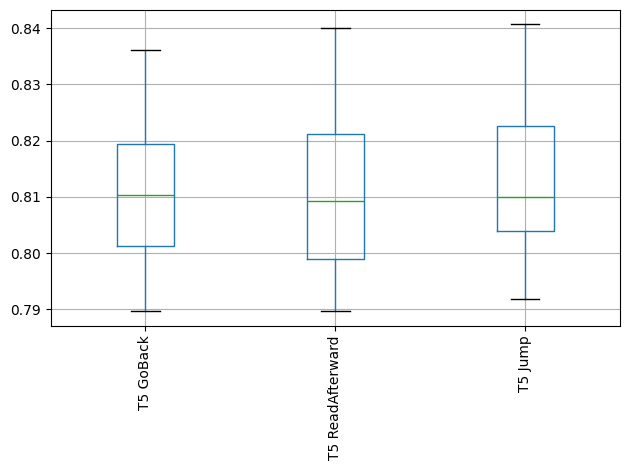

In [12]:
import matplotlib.pyplot as plt

scoresT5 = {
    'T5 GoBack': F1_t51,
    'T5 ReadAfterward': F1_t52,
    'T5 Jump': F1_t53
}

df_scoresT5 = pd.DataFrame(scoresT5)

df_scoresT5.boxplot()
plt.xticks(ticks=range(1, len(df_scoresT5.columns) + 1), labels=df_scoresT5.columns, rotation=90)
plt.tight_layout()
plt.show()

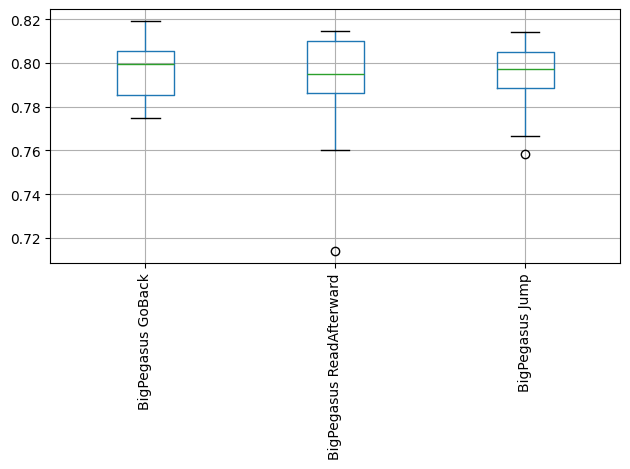

In [13]:
scoresBigPegasus = {
    'BigPegasus GoBack': F1_bigpegasus1,
    'BigPegasus ReadAfterward': F1_bigpegasus2,
    'BigPegasus Jump': F1_bigpegasus3
}

df_scoresBigPegasus = pd.DataFrame(scoresBigPegasus)

df_scoresBigPegasus.boxplot()
plt.xticks(ticks=range(1, len(df_scoresBigPegasus.columns) + 1), labels=df_scoresBigPegasus.columns, rotation=90)
plt.tight_layout()
plt.show()

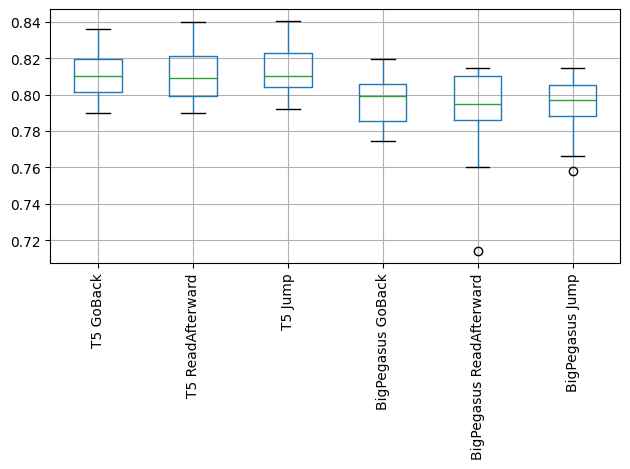

In [14]:
complete_view = {
    'T5 GoBack': F1_t51,
    'T5 ReadAfterward': F1_t52,
    'T5 Jump': F1_t53,
    'BigPegasus GoBack': F1_bigpegasus1,
    'BigPegasus ReadAfterward': F1_bigpegasus2,
    'BigPegasus Jump': F1_bigpegasus3
}

df_complete_view = pd.DataFrame(complete_view)

df_complete_view.boxplot()
plt.xticks(ticks=range(1, len(df_complete_view.columns) + 1), labels=df_complete_view.columns, rotation=90)
plt.tight_layout()
plt.show()

In [15]:
from scipy.stats import kruskal

kruskal_result = kruskal(scoresT5['T5 GoBack'], \
                         scoresT5['T5 ReadAfterward'], \
                         scoresT5['T5 Jump'])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least 2 groups (T5).")
else:
    print("No statistically relevant difference between groups (T5).")
###################################################
kruskal_result = kruskal(scoresBigPegasus['BigPegasus GoBack'], \
                         scoresBigPegasus['BigPegasus ReadAfterward'], \
                         scoresBigPegasus['BigPegasus Jump'])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least 2 groups (BigPegasus).")
else:
    print("No statistically relevant difference between groups (BigPegasus).")
###################################################
kruskal_result = kruskal(complete_view['BigPegasus GoBack'], \
                         complete_view['BigPegasus ReadAfterward'], \
                         complete_view['BigPegasus Jump'], \
                         complete_view['T5 GoBack'], \
                         complete_view['T5 ReadAfterward'], \
                         complete_view['T5 Jump'])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least 2 groups.")
else:
    print("No statistically relevant difference between groups.")

Kruskal-Wallis statistic: 0.3786214660995977
p value: 0.8275293260282618
No statistically relevant difference between groups (T5).
Kruskal-Wallis statistic: 0.14006226719295906
p value: 0.9323647915848796
No statistically relevant difference between groups (BigPegasus).
Kruskal-Wallis statistic: 26.96294509058956
p value: 5.799807744085814e-05
There is a statistically relevant difference between at least 2 groups.
